# Data Science Bowl 2015

## Organize Data

- Create folder, then download files with kaggle-cli
- data_dir should have subfolders train/ and test/ containing folders of images sorted by category, and 130400 test images, respectively

In [1]:
# Imports
import os, sys, shutil, random
data_dir = '/home/ubuntu/fastai-data/plankton'

In [ ]:
# Organize directories
%cd $data_dir
%mkdir results
%mkdir valid
%mkdir temp
%mkdir temp2

In [2]:
# Path variables
train_path = os.path.join(data_dir,'train')
valid_path = os.path.join(data_dir,'valid')
test_path = os.path.join(data_dir,'test')
result_path = os.path.join(data_dir,'results')
temp_path = os.path.join(data_dir,'temp')
temp_path2 = os.path.join(data_dir,'temp2')

The following code moves 1/5 of the total training images, selected at random, to the validation set. The distribution of both sets should be similar though slightly different, as this is a simple rather than stratified sample.

In [ ]:
files = [os.path.join(valid_path,c,f) for c in os.listdir(train_path) for f in os.listdir(os.path.join(train_path,c))]
files = random.sample(files, int(len(files)*0.2))

for f in files:
    if not os.path.exists(os.path.dirname(f)):
        try:
            os.makedirs(os.path.dirname(f))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    
    shutil.move(f.replace('/valid/','/train/'), f)

### 1. Move/Copy data into appropriate directories

In [ ]:
name = 'test'
%cd $data_dir
%mv $name 'unknown'
%mkdir $name
%mv 'unknown' $name

In [ ]:
thisdir = '/home/ubuntu/fastai-notes/nbs/'
%cd $thisdir

## Augment Data

In [3]:
import utils; reload(utils)
from utils import *
from keras.layers.advanced_activations import PReLU
from keras.layers.core import MaxoutDense
from IPython.display import FileLink

# Instantiate plotting tool
%matplotlib inline

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
Using Theano backend.


According to [forums](http://forums.fast.ai/t/batch-size-effect-on-validation-accuracy/413) batch sizes of at least 64 is better for approximating true gradient (and I don't want to go higher as it would necesitate simplifying the model or reducing the image resolution to fit in memory). 

In [4]:
# Configuration variables
batch_size = 128
val_batch_size = batch_size*2

Data augmentation reduces overfitting and is an essential component of most modern neural nets. The rotation should have worked fine but I decided more extreme augmentation was not that helpful as my network was not overfitting much, vertical and horizontal flipping should end up making similar transformations, and excessive augmentation will reduce convergence speed.

The relatively small image size is so my network can reliably run without memory allocation problems, as that was a problem on my p2.xlarge instance.

In [5]:
from keras.preprocessing import image

def get_batch2(dirname, temp_dir=None, augment=True, shuffle=True):
    gen = image.ImageDataGenerator()
    if augment:
        gen = image.ImageDataGenerator(#rotation_range=360,
                                       width_shift_range=0.05,
                                       height_shift_range=0.05,
                                       shear_range=0.10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True)

    return gen.flow_from_directory(dirname,
                                  target_size=(48,48),
                                  class_mode='categorical',
                                  color_mode='grayscale',
                                  shuffle=shuffle,
                                  save_to_dir=temp_dir,
                                  batch_size=batch_size)

batches = get_batch2(train_path, temp_dir=None)
val_batches = get_batch2(valid_path, temp_dir=None, shuffle=True, augment=False)

Found 24269 images belonging to 121 classes.
Found 6067 images belonging to 121 classes.


### Verify augmentation

When my model was preforming poorly (~5% validation accuracy and stagnant from there) I suspected there might be a problem with the validation set construction and so was careful to check that the augmentation did not create drastic differences between the training and validation sets.

#### Check min/max/mean statistics

In [ ]:
for i in range(3):
    batch, labels = next(batches) # save 3 batches of images
    print('TRAINING | max: {} min: {} mean: {}'.format(np.max(batch), np.min(batch), np.mean(batch)))
    val_batch, labels = next(val_batches)
    print('VALIDATE | max: {} min: {} mean: {}\n'.format(np.max(val_batch), np.min(val_batch), np.mean(val_batch)))
    

#### Visualize augmented images

In [1]:
from keras.preprocessing import image
import random

plots([image.load_img(os.path.join(temp_path, img)) for img in random.sample(os.listdir(temp_path), 8)])
plots([image.load_img(os.path.join(temp_path2, img)) for img in random.sample(os.listdir(temp_path2), 8)])

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


NameError: name 'plots' is not defined

In [ ]:
# show distribution of images
train_dist = [len(os.listdir(os.path.join(train_path,c))) for c in os.listdir(train_path)]
valid_dist = [len(os.listdir(os.path.join(valid_path,c))) for c in os.listdir(valid_path)]
train_sum = sum(train_dist)
valid_sum = sum(valid_dist)
for i in range(121):
    print('{:5.3f}% training vs {:5.3f}% validation'
          .format(100*train_dist[i]/float(train_sum), 100*valid_dist[i]/float(valid_sum)))

## Build convolutional model

My initial model was based off a description of the [winning architecture](http://benanne.github.io/2015/03/17/plankton.html), without the rotation pooling and rolling parts. This did not lead to very good preformance - while the training accuracy would increase (though it wasn't that high, maybe 20%) the validation accuracy would be stagnant and very low (~5%).

After [asking around](http://forums.fast.ai/t/low-accuracy-but-overfitting/5537/11) I was advised to try building a very simple architecture and see if it worked at all. To my suprise one 512-param dense layer between an input batchnorm and output dense(121) was all that was needed for pretty good accuracy up to 40%, though it was clearly underfitting (training accuracy up to 10% lower than validation).

I then found a [simpler model](https://github.com/hjweide/NDSB/blob/master/net24.py) that achieved top ten, implemented in lasagne, and basically copied it in keras. This seems to work pretty well, with ~74% validation accuracy after 200 epochs at the default 0.001 learning rate (though the lr isn't that meaningful as I'm using Adam). Running for 300 epochs doesn't seem to improve this.

In [6]:
# super-simple model for testing
# actually model copied from https://github.com/hjweide/NDSB/blob/master/net24.py
model = Sequential([
    BatchNormalization(axis=1, input_shape=(1,48,48)),
    
    Convolution2D(256,4,4,init='he_uniform'), # convolution layers
    PReLU(),
    BatchNormalization(axis=1),
    MaxPooling2D(strides=(2,2)),
    Dropout(0.1),
    
    Convolution2D(384,3,3,init='he_uniform'),
    PReLU(),
    BatchNormalization(axis=1),
    MaxPooling2D(strides=(2,2)),
    Dropout(0.2),
    
    Convolution2D(1024,3,3,init='he_uniform'),
    PReLU(),
    BatchNormalization(axis=1),
    MaxPooling2D(strides=(2,2)),
    #Lambda(Maxout),
    Dropout(0.3),
    
    Flatten(),
    
    MaxoutDense(1024, nb_feature=2, init='he_uniform'),
    PReLU(),
    BatchNormalization(),
    Dropout(0.5),
    
    MaxoutDense(1024, nb_feature=2, init='he_uniform'),
    PReLU(),
    BatchNormalization(),
    Dropout(0.5,),
    
    Dense(121, activation='softmax', init='he_uniform')
])

model.summary()
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_1 (BatchNorma (None, 1, 48, 48)     2           batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 256, 45, 45)   4352        batchnormalization_1[0][0]       
____________________________________________________________________________________________________
prelu_1 (PReLU)                  (None, 256, 45, 45)   518400      convolution2d_1[0][0]            
____________________________________________________________________________________________________
batchnormalization_2 (BatchNorma (None, 256, 45, 45)   512         prelu_1[0][0]                    
___________________________________________________________________________________________

In [7]:
no_epochs = 100
model.optimizer.lr = .000001

model.load_weights(os.path.join(result_path,'final_weights_210epochs.hf5'))
model.fit_generator(batches,
                samples_per_epoch=batches.nb_sample,
                validation_data=val_batches,
                nb_val_samples=val_batches.nb_sample,
                nb_epoch=no_epochs)


Epoch 1/100
24269/24269 [==============================] - 230s - loss: 0.7939 - acc: 0.7526 - val_loss: 0.9118 - val_acc: 0.7440
Epoch 2/100
24269/24269 [==============================] - 228s - loss: 0.7937 - acc: 0.7511 - val_loss: 0.9070 - val_acc: 0.7496
Epoch 3/100
24269/24269 [==============================] - 230s - loss: 0.7981 - acc: 0.7538 - val_loss: 0.9258 - val_acc: 0.7432
Epoch 4/100
24269/24269 [==============================] - 229s - loss: 0.8011 - acc: 0.7477 - val_loss: 0.9096 - val_acc: 0.7397
Epoch 5/100
24269/24269 [==============================] - 228s - loss: 0.7933 - acc: 0.7522 - val_loss: 0.9262 - val_acc: 0.7416
Epoch 6/100
24269/24269 [==============================] - 228s - loss: 0.7831 - acc: 0.7516 - val_loss: 0.9077 - val_acc: 0.7432
Epoch 7/100
24269/24269 [==============================] - 228s - loss: 0.8056 - acc: 0.7461 - val_loss: 0.8916 - val_acc: 0.7488
Epoch 8/100
24269/24269 [==============================] - 228s - loss: 0.7999 - acc: 0.75

In [8]:
# Save weights
model.save_weights(os.path.join(result_path,'final_weights_310epochs.hf5'))

## Generate Predictions on Test Data

In [9]:
test_batches = image.ImageDataGenerator().flow_from_directory(test_path,
                                                             target_size=(48,48),
                                                             class_mode='categorical',
                                                             color_mode='grayscale',
                                                             shuffle=False,
                                                             batch_size=batch_size)

model.load_weights(os.path.join(result_path,'final_weights_310epochs.hf5'))
preds = model.predict_generator(test_batches, test_batches.nb_sample)


Found 130400 images belonging to 1 classes.


In [10]:
# imports
import numpy as np
from IPython.display import FileLink

In [29]:
ids = [os.path.split(f)[-1] for f in test_batches.filenames]
ids = np.expand_dims(ids, axis=1)
print(preds.shape)
subm = np.hstack([ids,preds])
subm[0]

(130400, 121)


array(['1.jpg', '1.11927320177e-05', '1.69221993189e-12', '1.67455866062e-07', '2.5532399377e-06',
       '3.67453935723e-07', '0.000899883802049', '0.00030377987423', '0.000209333928069',
       '0.00170310190879', '1.52098629915e-13', '0.000106084356958', '0.0018167673843',
       '0.000120061762573', '1.62218293553e-06', '1.0717430996e-05', '6.69723476676e-06',
       '1.68615414964e-07', '7.36322181183e-06', '4.63979773713e-07', '5.69406938666e-06',
       '6.57979171592e-06', '1.14658313066e-07', '1.46009128343e-07', '4.34908198343e-09',
       '6.18126941845e-05', '7.13295003152e-06', '8.95665380085e-06', '0.000146111735376',
       '1.42830538152e-06', '3.3244871247e-06', '2.34814501709e-06', '2.8121508594e-11',
       '9.34020044951e-06', '0.000768653932028', '0.0164761170745', '0.0242573413998',
       '0.0630942136049', '0.331187844276', '2.76640328423e-08', '9.00033483049e-05',
       '4.79042849832e-09', '2.73407447793e-08', '1.49117404362e-05', '5.08299035573e-06',
       

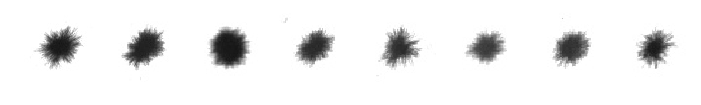

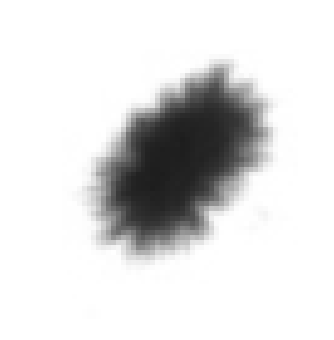

In [58]:
import random
plots([image.load_img(os.path.join(train_path, 'trichodesmium_puff', img)) for img in random.sample(os.listdir(os.path.join(train_path, 'trichodesmium_puff')), 8)])
plots([image.load_img(os.path.join(test_path, 'unknown', '10000.jpg'))])


In [54]:
import operator

subm_filename = 'plankton_subm2.csv'
classes = [i[0] for i in sorted(batches.class_indices.items(), key=operator.itemgetter(1))]
header='image,'+','.join(classes)

np.savetxt(subm_filename, subm, fmt='%s', delimiter=',', header=header, comments='')
FileLink(subm_filename)

/home/ubuntu/fastai-notes/nbs/plankton_subm2.csv

## Random Stuff

In [ ]:
no_epochs = 5
model.optimizer.lr = 0.00025
model.load_weights(os.path.join(result_path,'weights3_epoch6.hf5'))
for i in range(6, no_epochs+6):
    model.fit_generator(batches,
                    samples_per_epoch=batches.nb_sample,
                    validation_data=val_batches,
                    nb_val_samples=val_batches.nb_sample,
                    nb_epoch=1)
    weights_filename = 'weights3_epoch{}.hf5'.format(i+1)
    model.save_weights(os.path.join(result_path,weights_filename))
    model.optimizer.lr *= 0.1

In [ ]:
no_epochs = 30
model.load_weights(os.path.join(result_path,'weights3_epoch5.hf5'))
model.optimizer.lr = 0.00000001
for i in range(10, no_epochs+10):
    model.fit_generator(batches,
                    samples_per_epoch=batches.nb_sample,
                    validation_data=val_batches,
                    nb_val_samples=val_batches.nb_sample,
                    nb_epoch=1)
    weights_filename = 'weights3_epoch{}.hf5'.format(i+1)
    model.save_weights(os.path.join(result_path,weights_filename))
    model.optimizer.lr *= 0.01

In [ ]:
from keras import backend as K

def Maxout(x, num_unit=None):
    # Maxout as in the paper `Maxout Networks <http://arxiv.org/abs/1302.4389>`_.
    input_shape = x._keras_shape
    ndim = len(input_shape)
    assert ndim == 4 or ndim == 2

    data_format = K.image_dim_ordering()

    if data_format == 'th':
        ch = input_shape[1]
    else:
        ch = input_shape[-1]

    if num_unit == None:
        num_unit = ch / 2
    assert ch is not None and ch % num_unit == 0

    if ndim == 4:
        if data_format == 'th':
            x = K.permute_dimensions(x, (0, 2, 3, 1))
        x = K.reshape(x, (-1, input_shape[2], input_shape[3], ch / num_unit, num_unit))
        x = K.max(x, axis=3)
        if data_format == 'th':
            x = K.permute_dimensions(x, (0, 3, 1, 2))
    else:
        print('1.')
        x = K.reshape(x, (-1, ch / num_unit, num_unit))
        print('2.')
        x = K.max(x, axis=1)

    return x

### Old model (doesn't work well)

In [ ]:
model = Sequential([
    BatchNormalization(axis=1, input_shape=(1,224,224)), # automatically normalize inputs
    Convolution2D(32,3,3, border_mode='same', init='he_uniform'), # convolution layers
    PReLU(),
    BatchNormalization(axis=1),
    Convolution2D(32,1,1, border_mode='same', init='he_uniform'), # depthwise seperate?
    PReLU(),
    BatchNormalization(axis=1),
    Convolution2D(16,3,3, border_mode='same', init='he_uniform'),
    MaxPooling2D((4,4)), # max pooling
    PReLU(),
    BatchNormalization(axis=1),
    Dropout(0.2),
    Convolution2D(64,3,3, border_mode='same', init='he_uniform'),
    PReLU(),
    BatchNormalization(axis=1),
    Convolution2D(128,3,3, border_mode='same', init='he_uniform'),
    PReLU(),
    BatchNormalization(axis=1),
    Convolution2D(128,1,1, border_mode='same', init='he_uniform'), # depthwise seperate?
    PReLU(),
    BatchNormalization(axis=1),
    Convolution2D(64,3,3, border_mode='same', init='he_uniform'),
    PReLU(),
    BatchNormalization(axis=1),
    
    Flatten(),
    Dense(512, init='he_uniform'),
    PReLU(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, init='he_uniform'),
    PReLU(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(121, activation='softmax', init='he_uniform')
])

model.summary()
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])